# Buy when the price is low, and sell when the price is high

In [15]:
# Imports of Library

from pandas_datareader import data
import pandas as pd
import numpy as np

DataReader takes four arguments:
1. The first one is the symbol you would like to use for analysis.
2. The second specifies the source for retrieving the data, and then you will specify the range of days to get the data.
3. The third specifies the starting data from which to fetch historical data.
4. The fourth and final argument specifies the end data for the historical data series

In [4]:
# First Day
start_date = '2014-01-01'

# Last Day
end_date = '2018-01-01'

goog_data = data.DataReader('GOOG','yahoo',start_date,end_date)
goog_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-12-31,558.406982,551.064453,554.043335,558.262512,2725979.0,558.262512
2014-01-02,556.788025,552.060730,555.647278,554.481689,3656454.0,554.481689
2014-01-03,556.379578,550.401978,555.418152,550.436829,3345894.0,550.436829
2014-01-06,557.340942,551.154114,554.426880,556.573853,3551864.0,556.573853
2014-01-07,567.717041,558.486633,560.399475,567.303589,5124336.0,567.303589


There are six columns:
1. **High:** The highest price of the stock on that trading day.
2. **Low:** The lowest price of the stock on that trading day.
3. **Close:** The price of the stock at closing time.
4. **Open:** The price of the stock at the beginning of the trading day (closing price of the previous trading day).
5. **Volume:** How many stocks were traded.
6. **Adj Close:** The closing price of the stock that adjusts the price of the stock for corporate actions. This price takes into account the stock splits and dividends.

## Strategy

We will calculate the difference in the adjusted close between two consecutive days. If the value of the adjusted close is negative, this means the price on the previous day was higher than the price the following day, so we can buy since the price is lower now. If this value is positive, this means that we can sell because the price is higher.

In [10]:
goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']

goog_data_signal.head()

,price
Date,
2013-12-31,558.262512
2014-01-02,554.481689
2014-01-03,550.436829
2014-01-06,556.573853
2014-01-07,567.303589


In [13]:
goog_data_signal['daily_difference'] = goog_data_signal['price'].diff()
goog_data_signal.head()

,price,daily_difference
Date,,
2013-12-31,558.262512,NaN
2014-01-02,554.481689,-3.780823
2014-01-03,550.436829,-4.044861
2014-01-06,556.573853,6.137024
2014-01-07,567.303589,10.729736


We will create the signal based on the values of the column, daily_difference. If the value is positive, we will give the value 1, otherwise, the value will remain 0

In [17]:
goog_data_signal['signal'] = 0
goog_data_signal['signal'] = np.where(goog_data_signal['daily_difference'] > 0, 1, 0)

goog_data_signal.head()

,price,daily_difference,signal
Date,,,
2013-12-31,558.262512,NaN,0
2014-01-02,554.481689,-3.780823,0
2014-01-03,550.436829,-4.044861,0
2014-01-06,556.573853,6.137024,1
2014-01-07,567.303589,10.729736,1


Since we don't want to constantly buy if the market keeps moving down, or constantly sell when the market is moving up, we will limit the number of orders by restricting ourselves to the number of positions on the market. The position is your inventory of stocks or assets that you have on the market. For instance, if you buy one Google share, this means you have a position of one share on the market. If you sell this share, you will not have any positions on the market.

To simplify our example and limit the position on the market, it will be impossible to buy or sell more than one time consecutively. Therefore, we will apply diff() to the column signal:

In [19]:
goog_data_signal['positions'] = goog_data_signal['signal'].diff()
goog_data_signal.head(10)

,price,daily_difference,signal,positions
Date,,,,
2013-12-31,558.262512,NaN,0,NaN
2014-01-02,554.481689,-3.780823,0,0.0
2014-01-03,550.436829,-4.044861,0,0.0
2014-01-06,556.573853,6.137024,1,1.0
2014-01-07,567.303589,10.729736,1,0.0
2014-01-08,568.484192,1.180603,1,0.0
2014-01-09,563.009705,-5.474487,0,-1.0
2014-01-10,562.979797,-0.029907,0,0.0
2014-01-13,559.393250,-3.586548,0,0.0


## Signal Visualization

While creating signals is just the beginning of the process of building a trading strategy, we need to visualize how the strategy performs in the long term. We will plot the graph of the historical data we used by using the matplotlib library.

In [22]:
import matplotlib.pyplot as plt

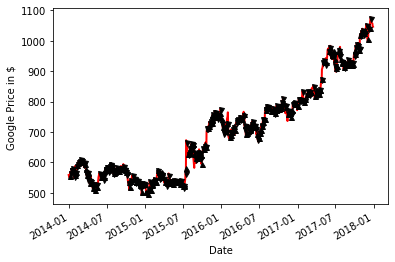

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111,ylabel='Google Price in $')
goog_data_signal['price'].plot(ax=ax1,color='r',lw=2)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1].index, goog_data_signal.price[goog_data_signal.positions == 1],'^',markersize=5,color='k')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1].index, goog_data_signal.price[goog_data_signal.positions == -1],'v',markersize=5,color='k')
plt.show()

## Backtesting
Backtesting is a key phase to get statistics showing how effective the trading strategy is. As we previously learned, the backtesting relies on the assumption that the past predicts the future


Important terms for backtesting:

1. **Profit and loss (P and L):** The money made by the strategy without transaction fees.
2. **Net profit and loss (net P and L):** The money made by the strategy with transaction fees.
3. **Exposure:** The capital invested.
4. **Number of trades:** The number of trades placed during a trading session.
5. **Annualized return:** This is the return for a year of trading.
6. **Sharpe ratio:** The risk-adjusted return. This data is important because it compares the return of the strategy with a risk-free strategy

For the purpose of backtesting, we will have a portfolio (grouping of financial assets such as bonds and stocks) composed of only one type of stock: Google (GOOG). We will start this portfolio with $1,000

In [44]:
initial_capital = float(1000.0)

Now, we will create a data frame for the positions and the portfolio:

In [45]:
positions = pd.DataFrame(index=goog_data_signal.index).fillna(0.0)
portfolio = pd.DataFrame(index=goog_data_signal.index).fillna(0.0)

Next, we will store the GOOG positions in the following data frame:

In [46]:
positions['GOOG'] = goog_data_signal['signal']

Then, we will store the amount of the GOOG positions for the portfolio in this one:

In [47]:
portfolio['positions'] = (positions.multiply(goog_data_signal['price'],axis=0))

Next, we will calculate the non-invested money (cash):

In [48]:
portfolio['cash'] = initial_capital - (positions.diff().multiply(goog_data_signal['price'], axis=0)).cumsum()

The total investment will be calculated by summing the positions and the cash

In [49]:
portfolio['total'] = portfolio['positions'] + portfolio['cash']

In [50]:
portfolio

,positions,cash,total
Date,,,
2013-12-31,0.000000,NaN,NaN
2014-01-02,0.000000,1000.000000,1000.000000
2014-01-03,0.000000,1000.000000,1000.000000
2014-01-06,556.573853,443.426147,1000.000000
2014-01-07,567.303589,443.426147,1010.729736
...,...,...,...
2017-12-22,0.000000,1253.277466,1253.277466
2017-12-26,0.000000,1253.277466,1253.277466
2017-12-27,0.000000,1253.277466,1253.277466
